# Abundance maps

Generate large scale maps of abundance of individual branches using a 50km grid.

In [63]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely

Load all buildings represented as points.

In [2]:
complete = gpd.read_parquet("/data/uscuni-boundaries/classification/")

In [14]:
boundaries = gpd.read_file(
    "/data/uscuni-boundaries/impact_boundaries.gpkg",
    layer="1994_political",
)

In [15]:
lt = gpd.read_file(
    "https://media.githubusercontent.com/media/wmgeolab/geoBoundaries/9469f09592ced973a3448cf66b6100b741b64c0d/releaseData/gbOpen/LTU/ADM0/geoBoundaries-LTU-ADM0-all.zip",
    layer="geoBoundaries-LTU-ADM0_simplified",
).to_crs(boundaries.crs)

In [4]:
complete

,geometry,level_7_label,area
16242_133192,POINT (4292815.658 3392096.245),36,124.350225
16242_134104,POINT (4292819.583 3392091.712),36,1.402272
16242_134103,POINT (4292810.814 3392094.661),36,14.988636
16242_133563,POINT (4292809.522 3392043.982),36,23.192214
16242_132995,POINT (4294130.039 3392097.282),57,65.245111
...,...,...,...
3221_48486,POINT (4128415.517 2896813.41),26,55.429514
3221_48478,POINT (4128415.095 2896819.459),26,59.189652
3221_48483,POINT (4128396.856 2896812.442),26,34.162277
3221_48507,POINT (4128396.626 2896802.56),26,16.241510


Map ids to level 3.

In [5]:
final_clusters = pd.read_parquet(
    "/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v10.pq"
)
complete["level_3"] = complete.level_7_label.map(final_clusters[3])
complete["level_2"] = complete.level_7_label.map(final_clusters[2])
complete["level_1"] = complete.level_7_label.map(final_clusters[1])

Make a grid

In [6]:
grid_size = 50_000

In [7]:
bds = complete.total_bounds
bds

array([1548185.539145  ,  942249.56623092, 5378847.07173358,
       3799811.41843362])

In [8]:
x = np.arange(bds[0], bds[2], grid_size)
y = np.arange(bds[1], bds[3], grid_size)

In [9]:
xs, ys = np.meshgrid(x, y)

In [19]:
grid = gpd.GeoSeries.from_xy(x=xs.flatten(), y=ys.flatten(), crs=complete.crs).buffer(
    grid_size / 2, cap_style="square"
)

In [20]:
grid = grid.iloc[grid.sindex.query(pd.concat([boundaries.geometry, lt.geometry]), predicate='intersects')[1]]

Join grid label to points

In [22]:
grid = grid.to_frame("geometry")
joined = complete.sjoin(grid, predicate="within")

Group by grid label and get counts by class.

In [23]:
counts_l3 = joined.groupby("index_right").level_3.value_counts().unstack().fillna(0)
counts_l3 = counts_l3.div(counts_l3.sum(axis=1), axis=0)
counts_l3

level_3,1,2,3,4,5,6,7,8
index_right,,,,,,,,
2601,0.012609,0.000000,0.159069,0.478177,0.173618,0.000000,0.176528,0.000000
2602,0.028092,0.040836,0.042055,0.370346,0.349069,0.000000,0.150875,0.018728
2603,0.003402,0.005254,0.080602,0.529489,0.289872,0.000000,0.087137,0.004244
2604,0.000168,0.000000,0.190332,0.409466,0.290719,0.014317,0.078154,0.016844
2673,0.001332,0.000424,0.077552,0.563991,0.294527,0.000000,0.056968,0.005206
...,...,...,...,...,...,...,...,...
4460,0.000000,0.000000,0.007194,0.410072,0.582734,0.000000,0.000000,0.000000
4461,0.002127,0.000000,0.057781,0.385502,0.331266,0.000000,0.223325,0.000000
4462,0.002161,0.000000,0.246345,0.426084,0.296937,0.000000,0.027075,0.001398


In [26]:
counts_l3

level_3,1,2,3,4,5,6,7,8
index_right,,,,,,,,
2601,0.012609,0.000000,0.159069,0.478177,0.173618,0.000000,0.176528,0.000000
2602,0.028092,0.040836,0.042055,0.370346,0.349069,0.000000,0.150875,0.018728
2603,0.003402,0.005254,0.080602,0.529489,0.289872,0.000000,0.087137,0.004244
2604,0.000168,0.000000,0.190332,0.409466,0.290719,0.014317,0.078154,0.016844
2673,0.001332,0.000424,0.077552,0.563991,0.294527,0.000000,0.056968,0.005206
...,...,...,...,...,...,...,...,...
4460,0.000000,0.000000,0.007194,0.410072,0.582734,0.000000,0.000000,0.000000
4461,0.002127,0.000000,0.057781,0.385502,0.331266,0.000000,0.223325,0.000000
4462,0.002161,0.000000,0.246345,0.426084,0.296937,0.000000,0.027075,0.001398


Plot

In [73]:
boundaries['code'] = ["AT", "CZ", "DE", "PL", "SK"]
boundaries['point'] = shapely.get_point(shapely.maximum_inscribed_circle(boundaries.geometry), 0)

lt['code'] = ["LT"]
lt['point'] = shapely.get_point(shapely.maximum_inscribed_circle(lt.geometry), 0)

In [74]:
def plot_label(label, ax):
    grid_data.plot(
        ax=ax,
        color=cmap[label],
        alpha=grid_data[label].fillna(0) / grid_data[label].max(),
    )
    boundaries.boundary.plot(ax=ax, color="k", zorder=2, linewidth=0.5)
    lt.boundary.plot(ax=ax, color="k", zorder=2, linewidth=0.5)
    for i, row in boundaries.iterrows():
        ax.text(row.point.x, row.point.y, row.code, horizontalalignment='center', verticalalignment='center' ,       fontsize="xx-small",)
    for i, row in lt.iterrows():
        ax.text(row.point.x, row.point.y, row.code, horizontalalignment='center', verticalalignment='center' ,       fontsize="xx-small",)
    

In [55]:
boundaries

,NAME,NOTES,geometry,code,point
0,Austria,None,"MULTIPOLYGON (((4355225.354 2715902.995, 43542...",AT,POINT (4681924.721 2741688.988)
1,Czechia,None,"MULTIPOLYGON (((4623550.104 3113763.447, 46305...",CZ,POINT (4730745.162 2976258.532)
2,Germany,None,"MULTIPOLYGON (((4355225.354 2715902.995, 43557...",DE,POINT (4327095.494 3108901.287)
3,Poland,None,"MULTIPOLYGON (((4922206.626 3502100.945, 49317...",PL,POINT (4944275.677 3251431.675)
4,Slovakia,None,"MULTIPOLYGON (((5029148.516 2968082.296, 50325...",SK,POINT (4969539.423 2880201.282)


In [81]:
grid_data = grid.join(counts_l3)

In [82]:
cmap = [
    "#4069BC",
    "#7CBAE4",
    "#E69C63",
    "#eec1d5",
    "#E0665F",
    "#ECBF43",
    "#b2cd32",
    "#1F943E",
]
cmap = {i: col for i, col in enumerate(cmap, 1)}

names = {
    1: "Incoherent Large-Scale \nHomogeneous Fabric",
    2: "Incoherent Large-Scale \nHeterogeneous Fabric",
    3: "Incoherent Small-Scale \nLinear Fabric",
    4: "Incoherent Small-Scale \nSparse Fabric",
    5: "Incoherent Small-Scale \nCompact Fabric",
    6: "Coherent Interconnected \nFabric",
    7: "Coherent Dense Disjoint \nFabric",
    8: "Coherent Dense Adjacent \nFabric",
}

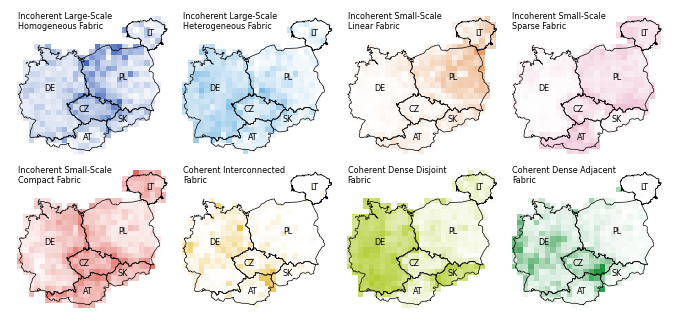

In [83]:
fig, axs = plt.subplots(2, 4, figsize=(8.5, 4), sharex=True, sharey=True)
for label, ax in enumerate(axs.flat, 1):
    plot_label(label, ax)
    ax.set_axis_off()
    ax.text(
        0.05,
        0.99,
        names[label],
        fontsize="xx-small",
        transform=ax.transAxes,
        verticalalignment="top",
    )
fig.subplots_adjust(wspace=0.00, hspace=0.00)
fig.savefig("../figs/abundance_l3.png", bbox_inches="tight", dpi=300)

## Level 2

In [34]:
counts_l2 = joined.groupby("index_right").level_2.value_counts().unstack().fillna(0)
counts_l2 = counts_l2.div(counts_l2.sum(axis=1), axis=0)
counts_l2

level_2,1,2,3,4
index_right,,,,
2601,0.012609,0.810863,0.000000,0.176528
2602,0.068927,0.761469,0.000000,0.169603
2603,0.008656,0.899963,0.000000,0.091381
2604,0.000168,0.890517,0.014317,0.094997
2673,0.001756,0.936070,0.000000,0.062175
...,...,...,...,...
4460,0.000000,1.000000,0.000000,0.000000
4461,0.002127,0.774548,0.000000,0.223325
4462,0.002161,0.969366,0.000000,0.028473


Plot

In [78]:
grid_data = grid.join(counts_l2)

In [79]:
cmap = ["#4069BC", "#eec1d5", "#ECBF43", "#b2cd32"]
cmap = {i: col for i, col in enumerate(cmap, 1)}

names = {
    1: "Incoherent Large-Scale \nFabric",
    2: "Incoherent Small-Scale \nFabric",
    3: "Coherent Interconnected \nFabric",
    4: "Coherent Dense \nFabric",
}

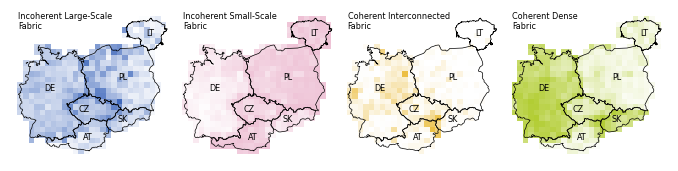

In [80]:
fig, axs = plt.subplots(1, 4, figsize=(8.5, 2), sharex=True, sharey=True)
for label, ax in enumerate(axs.flat, 1):
    plot_label(label, ax)
    ax.set_axis_off()
    ax.text(
        0.05,
        0.99,
        names[label],
        fontsize="xx-small",
        transform=ax.transAxes,
        verticalalignment="top",
    )
fig.subplots_adjust(wspace=0.00, hspace=0.00)
fig.savefig("../figs/abundance_l2.png", bbox_inches="tight", dpi=300)

## Level 1

In [43]:
counts_l1 = joined.groupby("index_right").level_1.value_counts().unstack().fillna(0)
counts_l1 = counts_l1.div(counts_l1.sum(axis=1), axis=0)
counts_l1

level_1,1,2
index_right,,
2601,0.823472,0.176528
2602,0.830397,0.169603
2603,0.908619,0.091381
2604,0.890686,0.109314
2673,0.937825,0.062175
...,...,...
4460,1.000000,0.000000
4461,0.776675,0.223325
4462,0.971527,0.028473


Plot

In [44]:
grid_data = grid.join(counts_l1)

In [46]:
cmap = ["#4069BC", "#ECBF43"]
cmap = {i: col for i, col in enumerate(cmap, 1)}

names = {
    1: "Incoherent Fabric",
    2: "Coherent Fabric",
}

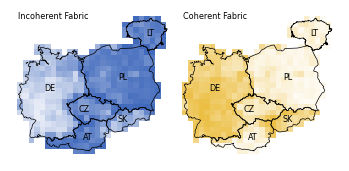

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(4.25, 2), sharex=True, sharey=True)
for label, ax in enumerate(axs.flat, 1):
    plot_label(label, ax)
    ax.set_axis_off()
    ax.text(
        0.05,
        0.99,
        names[label],
        fontsize="xx-small",
        transform=ax.transAxes,
        verticalalignment="top",
    )
fig.subplots_adjust(wspace=0.00, hspace=0.00)
fig.savefig("../figs/abundance_l1.png", bbox_inches="tight", dpi=300)